# [*Lab Project Part 2*]() CNNs for Image Classification
------------------------------

### General Guideline
1. Aim:
    - *Understand  the  basic  Image  Classification/Recognition  pipeline  and  the  data-driven  approach (train/predict stages).*
    - *Get used to one of deep learning framework(Pytorch).*
2. Prerequisite:
    - *Familiar with python and relevant packages.*
    - *Known the basic knowledge of Convolutional Neural Networks*

### PyTorch versions
we assume that you are using latest PyTorch version(>=1.4)

### PyTorch Tutorial & Docs
You can learn pytorch from the [tutorial link](https://pytorch.org/tutorials/). The Docs information can be searched at [Docs](https://pytorch.org/docs/stable/index.html). In this assignments, we wish you to form the basic capability of using one of the well-known  

## Session 1: Image Classifiation on CIFAR 10
### Install pytorch and run the given codes

In [93]:
#####################################################
# referenced codes: https://pytorch.org/tutorials/
# referenced codes: http://cs231n.stanford.edu/
# referenced codes: https://cs.stanford.edu/~acoates/stl10/
######################################################
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
import pickle
import os
import copy
from sklearn.manifold import TSNE

In [94]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


####  *` Q2.1: test dataloader and show the images of each class  of CIFAR10`*  

In [95]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.yticks([18 + i*34 for i in range(len(classes))], classes, fontsize=15)
    plt.xticks([])
    plt.tick_params(length=0)
    plt.show()

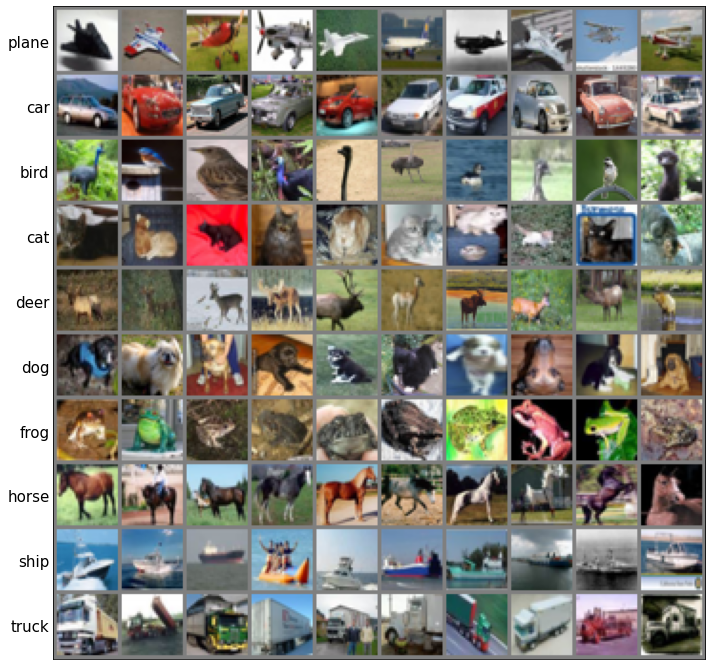

In [96]:
# get 10 training images of each class
images = []
for class_ in range(len(classes)):
    for image, label in trainset:
        if label == class_:
            images.append(image)
        if len(images) == (class_ + 1)*10:
            break

# show images
imshow(torchvision.utils.make_grid(images, nrow=10, padding=2))

####  *` Q2.2: Architecture understanding. Implement architecture of TwolayerNet and ConvNet.`*  

In [97]:
class TwolayerNet(nn.Module):
    # assign layer objects to class attributes
    # nn.init package contains convenient initialization methods
    # http://pytorch.org/docs/master/nn.html#torch-nn-init
    def __init__(self,input_size ,hidden_size ,num_classes ):
        '''
        :param input_size: 3*32*32
        :param hidden_size: 
        :param num_classes: 
        '''
        ################################
        super(TwolayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        ################################
        
    def forward(self,x):
        # flatten
        x = x.view(x.shape[0], -1)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores


In [98]:
class ConvNet(nn.Module):
    # Complete the code using LeNet-5
    # reference: https://ieeexplore.ieee.org/document/726791
    def __init__(self):
        ################################
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
        ################################
        
    def forward(self, x):
        ################################
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        
        x = x.view(x.shape[0], -1)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        ################################
        
        return x

In [99]:
def train(net, trainloader,epoch=1, verbose=False):
    ###################### Define Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss_history = []
    ############################### Training
    for curr_epoch in range(epoch):  # loop over the dataset multiple times 

        ################################
        running_loss = 0.0
        print_freq = 1000
        for idx, data  in enumerate(trainloader):            
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            out = net(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if idx % print_freq == (print_freq - 1):
                loss_history.append(running_loss / print_freq)
                if verbose:
                    print("(Epoch %d, Iter %d)  train_loss: %.4f" % (curr_epoch + 1, idx + 1, loss_history[-1]))
                running_loss = 0.0
        ################################

    return loss_history
    print('Finished Training')

####  Train Two-layer Net

In [82]:
################################
tl_net = TwolayerNet(3*32*32, 50, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_net.to(device)
tl_loss_history = train(tl_net, trainloader, verbose=True)

################################

(Epoch 1, Iter 1000)  train_loss: 1.9351
(Epoch 1, Iter 2000)  train_loss: 1.7538
(Epoch 1, Iter 3000)  train_loss: 1.7269
(Epoch 1, Iter 4000)  train_loss: 1.6983
(Epoch 1, Iter 5000)  train_loss: 1.6941
(Epoch 1, Iter 6000)  train_loss: 1.6509
(Epoch 1, Iter 7000)  train_loss: 1.6581
(Epoch 1, Iter 8000)  train_loss: 1.6311
(Epoch 1, Iter 9000)  train_loss: 1.6305
(Epoch 1, Iter 10000)  train_loss: 1.5949
(Epoch 1, Iter 11000)  train_loss: 1.6249
(Epoch 1, Iter 12000)  train_loss: 1.6085


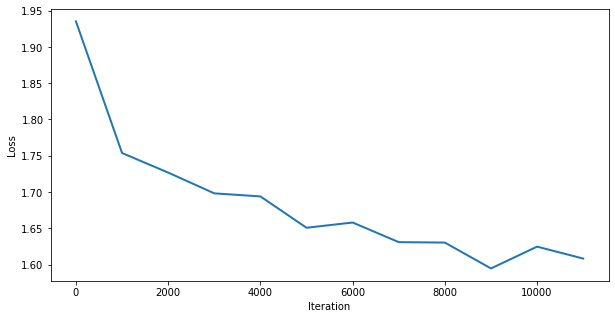

In [89]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(tl_loss_history)) * 1000 + 1, tl_loss_history, lw=2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

#### Train ConvNet

In [86]:
################################
convnet = ConvNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
convnet.to(device)
convnet_loss_history = train(convnet, trainloader, verbose=True)
################################

(Epoch 1, Iter 1000)  train_loss: 2.1299
(Epoch 1, Iter 2000)  train_loss: 1.9510
(Epoch 1, Iter 3000)  train_loss: 1.8775
(Epoch 1, Iter 4000)  train_loss: 1.8209
(Epoch 1, Iter 5000)  train_loss: 1.7831
(Epoch 1, Iter 6000)  train_loss: 1.7456
(Epoch 1, Iter 7000)  train_loss: 1.7559
(Epoch 1, Iter 8000)  train_loss: 1.7130
(Epoch 1, Iter 9000)  train_loss: 1.6560
(Epoch 1, Iter 10000)  train_loss: 1.6469
(Epoch 1, Iter 11000)  train_loss: 1.6047
(Epoch 1, Iter 12000)  train_loss: 1.5796


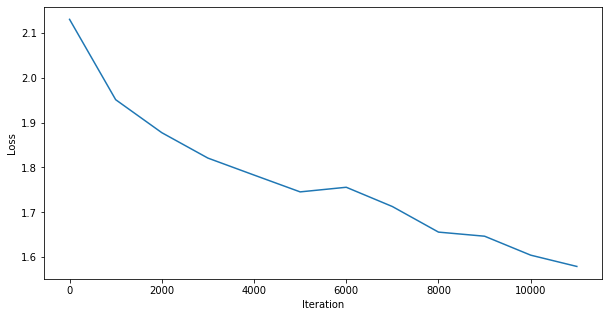

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(convnet_loss_history)) * 1000 + 1, convnet_loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [100]:
def valid(net,testloader, verbose=True):
    correct = 0
    total = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    if verbose:
        print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
    return correct / total

In [101]:
def valid_class(net,testloader,classes):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

####  *` Q2.3: Preparation of training. Create Dataloader yourself and define Transform, optimizer.`*  

#### *` Complement  CIFAR10_loader()`*

In [102]:
###  suggested reference: https://pytorch.org/tutorials/
# recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataloader
# functions to show an image

class CIFAR10_loader(Dataset):
    def __init__(self,root,train=True,transform = None):
        
        ################################
        self.root = root
        train = train
        train_files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]
        test_files = ["test_batch"]
        
        if train:
            self.images, self.labels = self.load_data(train_files)
        else:
            self.images, self.labels = self.load_data(test_files)
            
        self.transform = transform
        ################################
        
    def __len__(self):
        return len(self.labels)
    
    def load_data(self, files):
        images = []
        labels = []
        for file in files:
            dict = self.unpickle(os.path.join(self.root, "cifar-10-batches-py", file))
            images.append(dict[b"data"])
            labels += dict[b"labels"]
            
        images = np.concatenate(images, axis=0)
        images = images.reshape(-1, 32, 32, 3)
        return images, labels
    
    def unpickle(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def __getitem__(self, item):
        ################################
        img, target = self.images[item], self.labels[item]
        if self.transform is not None:
            img = self.transform(img)
        
        ################################

        return img, target

#### *` Complement Transform function and Optimizer`*

In [87]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform_train = transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10_loader(root='./data', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = CIFAR10_loader(root='./data', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

convnet = ConvNet()
convnet.to(device)
optimizer = optim.SGD(convnet.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#### *` Train the ConvNet with CIFAR10_loader, transform and optimizer you implemented and compare the results`*

In [103]:
def train(net, optimizer, criterion, trainloader,epoch=1, verbose=True):
    ###################### Define Loss function and optimizer
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss_history = []
    ############################### Training
    for curr_epoch in range(epoch):  # loop over the dataset multiple times 

        ################################
        running_loss = 0.0
        print_freq = 1000
        for idx, data  in enumerate(trainloader):            
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            out = net(inputs)
            loss = criterion(out, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if idx % print_freq == (print_freq - 1):
                loss_history.append(running_loss / print_freq)
                if verbose:
                    print("(Epoch %d, Iter %d)  train_loss: %.4f" % (curr_epoch + 1, idx + 1, loss_history[-1]))
                running_loss = 0.0
        ################################

    return loss_history

In [95]:
loss_history = train(convnet, optimizer, criterion, trainloader, verbose=True)

(Epoch 1, Iter 1000)  train_loss: 2.1581
(Epoch 1, Iter 2000)  train_loss: 1.9923
(Epoch 1, Iter 3000)  train_loss: 1.9498
(Epoch 1, Iter 4000)  train_loss: 1.8866
(Epoch 1, Iter 5000)  train_loss: 1.8608
(Epoch 1, Iter 6000)  train_loss: 1.8495
(Epoch 1, Iter 7000)  train_loss: 1.8372
(Epoch 1, Iter 8000)  train_loss: 1.7975
(Epoch 1, Iter 9000)  train_loss: 1.7438
(Epoch 1, Iter 10000)  train_loss: 1.7297
(Epoch 1, Iter 11000)  train_loss: 1.7062
(Epoch 1, Iter 12000)  train_loss: 1.6816


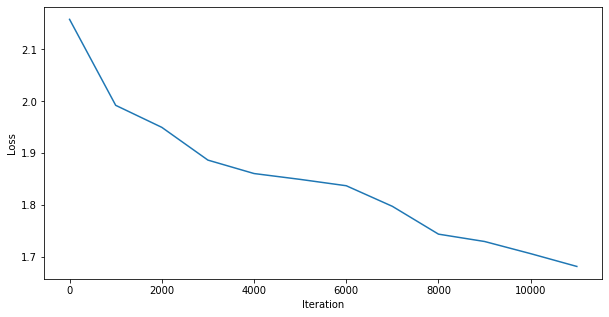

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(loss_history)) * 1000 + 1, loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

#### *` Q2.4 Setting up the hyperparameters.`*

#### *`Play with convNet and TwolayerNet, set up the hyperparameters and reach the accuracy as high as you can`*

In [104]:
def train(net, optimizer, criterion, trainloader,epoch=1, verbose=True):
    ###################### Define Loss function and optimizer
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss_history = []
    ############################### Training
    for curr_epoch in range(epoch):  # loop over the dataset multiple times 

        ################################
        running_loss = 0.0
        print_freq = 1000
        for idx, data  in enumerate(trainloader):            
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            out = net(inputs)
            loss = criterion(out, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            
        loss_history.append(running_loss / len(trainloader))
        if verbose:
            print("(Epoch %d)  train_loss: %.4f" % (curr_epoch + 1, loss_history[-1]))
        running_loss = 0.0
        ################################

    return loss_history

In [110]:
################################
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10_loader(root='./data', train=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=5)

testset = CIFAR10_loader(root='./data', train=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=5)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_train_loader(trainset, batch_size):
    return torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=5)
################################

#### *` test the accuracy of ConvNet `*

In [106]:
class CustomConvNet(nn.Module):
    # Complete the code using LeNet-5
    # reference: https://ieeexplore.ieee.org/document/726791
    def __init__(self, hidden_size):
        ################################
        super(CustomConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(120, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        ################################
        
    def classify(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
    def extract_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        return x
        
    def forward(self, x):
        ################################
        x = self.extract_features(x)
        x = self.classify(x)
        ################################
        
        return x

In [103]:
################################
best_acc = -1
best_conv_net = None
criterion = nn.CrossEntropyLoss()
best_config = None

for _ in range(20):
    lr = 10**np.random.uniform(-4, -2)
    batch_size = 2**np.random.randint(2, 7)
    hidden_size = np.random.randint(50, 100)

    trainloader = get_train_loader(trainset, batch_size)
    conv_net = CustomConvNet(hidden_size)
    conv_net.to(device)
    optimizer = optim.Adam(conv_net.parameters(), lr=lr)
    train(conv_net, optimizer, criterion, trainloader, epoch=5, verbose=False)

    conv_net.eval()
    val_accuracy = valid(conv_net, testloader, verbose=False)
    train_accuracy = valid(conv_net, trainloader, verbose=False)
    if val_accuracy > best_acc:
        best_config = (lr, batch_size, hidden_size)
        best_acc = val_accuracy
        best_net = copy.deepcopy(conv_net)
    print("(lr %.4f, batch_size %d, hidden_size %d): val_acc %.3f train_acc %.3f" % (lr, batch_size, hidden_size, val_accuracy, train_accuracy))
################################

(lr 0.0060, batch_size 8, hidden_size 54): val_acc 0.100 train_acc 0.100
(lr 0.0001, batch_size 8, hidden_size 56): val_acc 0.481 train_acc 0.488
(lr 0.0001, batch_size 8, hidden_size 71): val_acc 0.493 train_acc 0.493
(lr 0.0001, batch_size 32, hidden_size 87): val_acc 0.471 train_acc 0.479
(lr 0.0018, batch_size 8, hidden_size 75): val_acc 0.514 train_acc 0.542
(lr 0.0008, batch_size 4, hidden_size 73): val_acc 0.540 train_acc 0.596
(lr 0.0061, batch_size 4, hidden_size 57): val_acc 0.181 train_acc 0.184
(lr 0.0008, batch_size 64, hidden_size 61): val_acc 0.530 train_acc 0.552
(lr 0.0010, batch_size 32, hidden_size 54): val_acc 0.545 train_acc 0.579
(lr 0.0028, batch_size 16, hidden_size 85): val_acc 0.511 train_acc 0.537
(lr 0.0029, batch_size 4, hidden_size 81): val_acc 0.414 train_acc 0.414
(lr 0.0039, batch_size 8, hidden_size 77): val_acc 0.422 train_acc 0.436
(lr 0.0001, batch_size 64, hidden_size 50): val_acc 0.441 train_acc 0.439
(lr 0.0084, batch_size 16, hidden_size 77): va

In [42]:
lr = 0.001
batch_size = 32
hidden_size = 54
trainloader = get_train_loader(trainset, batch_size)
conv_net = CustomConvNet(hidden_size)
conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=lr)

best_acc = -1
best_net = None
results = {}
criterion = nn.CrossEntropyLoss()
best_config = None
loss_history = []
train_acc_history = []
val_acc_history = []

for i in range(50):
    conv_net.train()
    loss_history += train(conv_net, optimizer, criterion, trainloader,epoch=1, verbose=False)
    conv_net.eval()
    val_accuracy = valid(conv_net, testloader, verbose=False)
    train_accuracy = valid(conv_net, trainloader, verbose=False)
    val_acc_history.append(val_accuracy)
    train_acc_history.append(train_accuracy)
    if val_accuracy > best_acc:
        best_config = i + 1
        best_acc = val_accuracy
        best_net = copy.deepcopy(conv_net)
    print("Epochs trained %d: val_accuracy %.3f train_accuracy %.3f" % ((i+ 1), val_accuracy, train_accuracy))

    results[(i+ 1)* 10] = val_accuracy

Epochs trained 1: val_accuracy 0.445 train_accuracy 0.451
Epochs trained 2: val_accuracy 0.481 train_accuracy 0.494
Epochs trained 3: val_accuracy 0.505 train_accuracy 0.526
Epochs trained 4: val_accuracy 0.525 train_accuracy 0.552
Epochs trained 5: val_accuracy 0.540 train_accuracy 0.573
Epochs trained 6: val_accuracy 0.539 train_accuracy 0.580
Epochs trained 7: val_accuracy 0.546 train_accuracy 0.598
Epochs trained 8: val_accuracy 0.559 train_accuracy 0.617
Epochs trained 9: val_accuracy 0.537 train_accuracy 0.599
Epochs trained 10: val_accuracy 0.559 train_accuracy 0.628
Epochs trained 11: val_accuracy 0.555 train_accuracy 0.632
Epochs trained 12: val_accuracy 0.564 train_accuracy 0.638
Epochs trained 13: val_accuracy 0.569 train_accuracy 0.646
Epochs trained 14: val_accuracy 0.560 train_accuracy 0.658
Epochs trained 15: val_accuracy 0.558 train_accuracy 0.653
Epochs trained 16: val_accuracy 0.570 train_accuracy 0.672
Epochs trained 17: val_accuracy 0.562 train_accuracy 0.672
Epochs

In [118]:
valid(best_net, testloader, verbose=True)
valid_class(best_net, testloader, classes)

Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 60 %
Accuracy of   car : 76 %
Accuracy of  bird : 49 %
Accuracy of   cat : 37 %
Accuracy of  deer : 51 %
Accuracy of   dog : 40 %
Accuracy of  frog : 75 %
Accuracy of horse : 60 %
Accuracy of  ship : 68 %
Accuracy of truck : 52 %


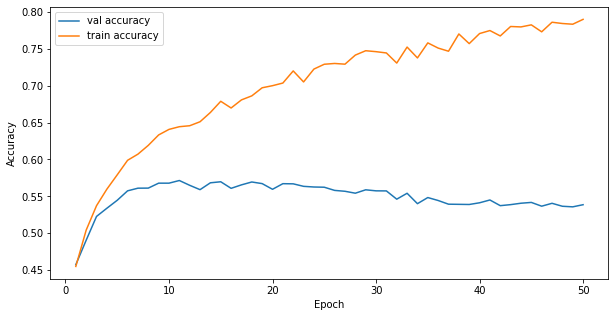

In [125]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(loss_history)) + 1, val_acc_history, label="val accuracy")
plt.plot(np.arange(len(loss_history)) + 1, train_acc_history, label="train accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

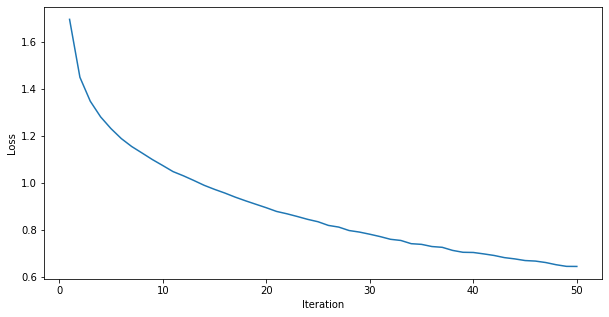

In [126]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(loss_history)) + 1, loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

#### *`test the accuracy of TwolayerNet`*

In [114]:
################################
best_acc = -1
best_tl_net = None
results = {}
criterion = nn.CrossEntropyLoss()
best_config = None

for _ in range(20):
    lr = 10**np.random.uniform(-4, -2)
    batch_size = 2**np.random.randint(2, 7)
    hidden_size = np.random.randint(50, 100)

    trainloader = get_train_loader(trainset, batch_size)
    tl_net = TwolayerNet(3*32*32, hidden_size, 10)
    tl_net.to(device)
    optimizer = optim.Adam(tl_net.parameters(), lr=lr)
    train(tl_net, optimizer, criterion, trainloader,epoch=2, verbose=False)

    tl_net.eval()
    val_accuracy = valid(tl_net, testloader, verbose=False)
    train_accuracy = valid(tl_net, trainloader, verbose=False)
    if val_accuracy > best_acc:
        best_config = (lr, batch_size, hidden_size)
        best_acc = val_accuracy
        best_tl_net = copy.deepcopy(tl_net)
    print("(lr %.4f, batch_size %d, hidden_size %d): val_acc %.3f train_acc %.3f" % (lr, batch_size, hidden_size, val_accuracy, train_accuracy))

    results[(lr, batch_size, hidden_size)] = val_accuracy
################################

(lr 0.0003, batch_size 4, hidden_size 59): val_acc 0.469 train_acc 0.501
(lr 0.0005, batch_size 16, hidden_size 64): val_acc 0.471 train_acc 0.498
(lr 0.0028, batch_size 16, hidden_size 74): val_acc 0.427 train_acc 0.444
(lr 0.0054, batch_size 32, hidden_size 73): val_acc 0.388 train_acc 0.406
(lr 0.0007, batch_size 32, hidden_size 69): val_acc 0.471 train_acc 0.509
(lr 0.0002, batch_size 8, hidden_size 65): val_acc 0.479 train_acc 0.508
(lr 0.0071, batch_size 4, hidden_size 82): val_acc 0.224 train_acc 0.224
(lr 0.0050, batch_size 16, hidden_size 94): val_acc 0.360 train_acc 0.362
(lr 0.0015, batch_size 4, hidden_size 92): val_acc 0.414 train_acc 0.428
(lr 0.0003, batch_size 32, hidden_size 67): val_acc 0.479 train_acc 0.507
(lr 0.0009, batch_size 64, hidden_size 72): val_acc 0.482 train_acc 0.511
(lr 0.0004, batch_size 4, hidden_size 53): val_acc 0.468 train_acc 0.499
(lr 0.0003, batch_size 16, hidden_size 55): val_acc 0.466 train_acc 0.498
(lr 0.0100, batch_size 64, hidden_size 72):

In [115]:
lr = 0.0009
batch_size = 64
hidden_size = 72
trainloader = get_train_loader(trainset, batch_size)
tl_net = TwolayerNet(3*32*32, hidden_size, 10)
tl_net.to(device)
optimizer = optim.Adam(tl_net.parameters(), lr=lr)

best_acc = -1
best_tl_net = None
results = {}
criterion = nn.CrossEntropyLoss()
best_config = None
loss_history = []
val_acc_history = []
train_acc_history = []

for i in range(50):
    tl_net.train()
    loss_history += train(tl_net, optimizer, criterion, trainloader,epoch=1, verbose=False)
    
    tl_net.eval()
    val_accuracy = valid(tl_net, testloader, verbose=False)
    train_accuracy = valid(tl_net, trainloader, verbose=False)
    val_acc_history.append(val_accuracy)
    train_acc_history.append(train_accuracy)
    if val_accuracy > best_acc:
        best_config = (i + 1)
        best_acc = val_accuracy
        best_tl_net = copy.deepcopy(tl_net)
    print("Epochs trained %d: val_accuracy %.3f train_accuracy %.3f" % ((i+ 1), val_accuracy, train_accuracy))

    results[(i+ 1)] = val_accuracy

Epochs trained 1: val_accuracy 0.467 train_accuracy 0.481
Epochs trained 2: val_accuracy 0.483 train_accuracy 0.511
Epochs trained 3: val_accuracy 0.487 train_accuracy 0.533
Epochs trained 4: val_accuracy 0.493 train_accuracy 0.549
Epochs trained 5: val_accuracy 0.506 train_accuracy 0.570
Epochs trained 6: val_accuracy 0.497 train_accuracy 0.570
Epochs trained 7: val_accuracy 0.507 train_accuracy 0.586
Epochs trained 8: val_accuracy 0.503 train_accuracy 0.594
Epochs trained 9: val_accuracy 0.511 train_accuracy 0.606
Epochs trained 10: val_accuracy 0.515 train_accuracy 0.616
Epochs trained 11: val_accuracy 0.510 train_accuracy 0.614
Epochs trained 12: val_accuracy 0.498 train_accuracy 0.614
Epochs trained 13: val_accuracy 0.500 train_accuracy 0.623
Epochs trained 14: val_accuracy 0.511 train_accuracy 0.641
Epochs trained 15: val_accuracy 0.507 train_accuracy 0.645
Epochs trained 16: val_accuracy 0.503 train_accuracy 0.649
Epochs trained 17: val_accuracy 0.505 train_accuracy 0.653
Epochs

In [116]:
valid(best_tl_net, testloader, verbose=True)
valid_class(best_tl_net, testloader, classes)

Accuracy of the network on the 10000 test images: 51 %
Accuracy of plane : 59 %
Accuracy of   car : 58 %
Accuracy of  bird : 35 %
Accuracy of   cat : 28 %
Accuracy of  deer : 49 %
Accuracy of   dog : 47 %
Accuracy of  frog : 62 %
Accuracy of horse : 55 %
Accuracy of  ship : 59 %
Accuracy of truck : 59 %


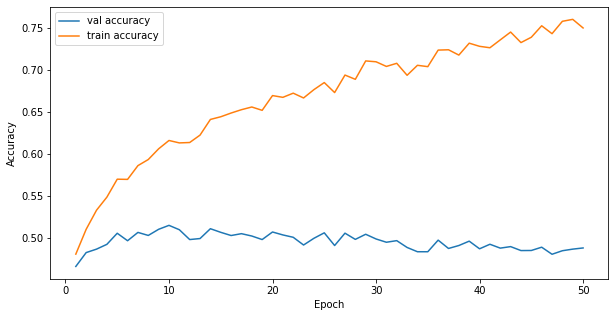

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(loss_history)) + 1, val_acc_history, label="val accuracy")
plt.plot(np.arange(len(loss_history)) + 1, train_acc_history, label="train accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

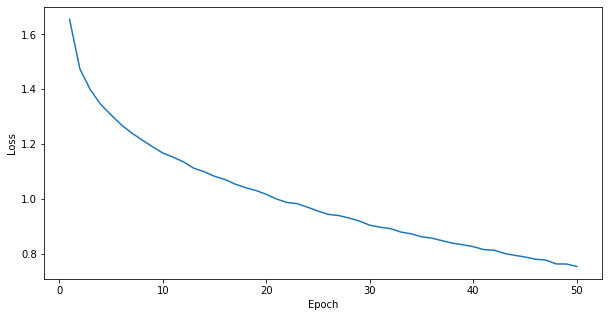

In [118]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(loss_history)) + 1, loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Session 2:  Finetuning the ConvNet
### STL-10 DATASET
> The provided network is trained on a different dataset named CIFAR-10 4 , which
contains the images of 10 different object categories, each of which has 32 ∗ 32 ∗ 3
dimensions. The dataset we use throughout the assignment is a subset of STL-10 5
with larger sizes and different object classes. So, there is a discrepancy between the
dataset we use to train (CIFAR-10) and test (STL-10) our network. One solution
would be to train the whole network from scratch. However, the number of param-
eters are too large to be trained properly with such few number of images provided.
One solution is to shift the learned weights in a way to perform well on the test
set, while preserving as much information as necessary from the training class.
### In this Session, extract 5 classes from STL training dataset , 
the the label of images can be defined as `{1: 'airplanes',2:'birds',3:'ships',4:'cats',5:'dogs'}`

#### *`Q3.1 create the STL10_Dataset `*

In [43]:
from stl10_input import *
class STL10_Dataset(Dataset):
    def __init__(self,root,train=True,transform = None):
        ################################
        self.root = root
        train = train
        train_files = ("train_X.bin", "train_y.bin")
        test_files = ("test_X.bin", "test_y.bin")
        
        if train:
            self.images, self.labels = self.load_data(train_files)
        else:
            self.images, self.labels = self.load_data(test_files)
            
        self.transform = transform
        ################################


    def __len__(self):
        ################################
        return len(self.labels)
        ################################
        
    def load_data(self, files):
        images = read_all_images(os.path.join(self.root, "stl10_binary", files[0]))
        labels = read_labels(os.path.join(self.root, "stl10_binary", files[1]))
        images = images[(labels == 1) | (labels == 2) | (labels == 9) | (labels == 4) | (labels == 6)]
        labels = labels[(labels == 1) | (labels == 2) | (labels == 9) | (labels == 4) | (labels == 6)]
        labels[labels == 1] = 0
        labels[labels == 2] = 1
        labels[labels == 9] = 2
        labels[labels == 4] = 3
        labels[labels == 6] = 4
        
        return images, labels

    def __getitem__(self, item):
        ################################
        img = self.images[item]
        target = self.labels[item]
        if self.transform is not None:
            img = self.transform(img)
        ################################

        return img, target


#### *`Q3.2  Finetuning from ConvNet & train the model and show the results`*

In [44]:
# update the last layers of the convnet to be able to process larger images and to only output 5 scores
for param in best_net.parameters():
    param.requires_grad = False
best_net.fc1 = nn.Linear(120*17*17, 54)
best_net.fc2 = nn.Linear(54, 5)
stl10_net = copy.deepcopy(best_net)
stl10_net.to(device)

CustomConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=34680, out_features=54, bias=True)
  (fc2): Linear(in_features=54, out_features=5, bias=True)
)

In [45]:
# load the data
batch_size = 32
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = STL10_Dataset(root='./data', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = STL10_Dataset(root='./data', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ("airplanes", "birds", "ships", "cats", "dogs")

In [46]:
# train the model
optimizer = optim.Adam(stl10_net.parameters(), lr=0.001)

best_acc = -1
best_stl10_net = None
results = {}
criterion = nn.CrossEntropyLoss()
best_config = None
loss_history = []
val_acc_history = []
train_acc_history = []

for i in range(50):
    stl10_net.train()
    loss_history += train(stl10_net, optimizer, criterion, trainloader,epoch=1, verbose=False)
    
    stl10_net.eval()
    val_accuracy = valid(stl10_net, testloader, verbose=False)
    val_acc_history.append(val_accuracy)
    train_accuracy = valid(stl10_net, trainloader, verbose=False)
    train_acc_history.append(train_accuracy)
    if val_accuracy > best_acc:
        best_config = (i + 1)
        best_acc = val_accuracy
        best_stl10_net = copy.deepcopy(stl10_net)
    print("Epochs trained %d: val_accuracy %.3f train_accuracy %.3f" % ((i + 1), val_accuracy, train_accuracy))

    results[(i+ 1)] = val_accuracy

Epochs trained 1: val_accuracy 0.518 train_accuracy 0.631
Epochs trained 2: val_accuracy 0.575 train_accuracy 0.784
Epochs trained 3: val_accuracy 0.600 train_accuracy 0.858
Epochs trained 4: val_accuracy 0.606 train_accuracy 0.933
Epochs trained 5: val_accuracy 0.546 train_accuracy 0.884
Epochs trained 6: val_accuracy 0.583 train_accuracy 0.946
Epochs trained 7: val_accuracy 0.612 train_accuracy 0.992
Epochs trained 8: val_accuracy 0.604 train_accuracy 0.995
Epochs trained 9: val_accuracy 0.622 train_accuracy 1.000
Epochs trained 10: val_accuracy 0.620 train_accuracy 1.000
Epochs trained 11: val_accuracy 0.625 train_accuracy 1.000
Epochs trained 12: val_accuracy 0.621 train_accuracy 1.000
Epochs trained 13: val_accuracy 0.624 train_accuracy 1.000
Epochs trained 14: val_accuracy 0.625 train_accuracy 1.000
Epochs trained 15: val_accuracy 0.625 train_accuracy 1.000
Epochs trained 16: val_accuracy 0.625 train_accuracy 1.000
Epochs trained 17: val_accuracy 0.622 train_accuracy 1.000
Epochs

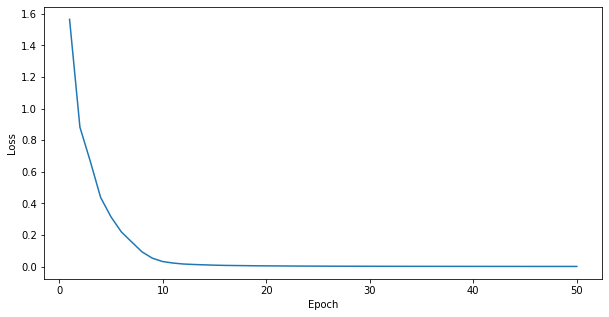

In [47]:
# plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(loss_history)) + 1, loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

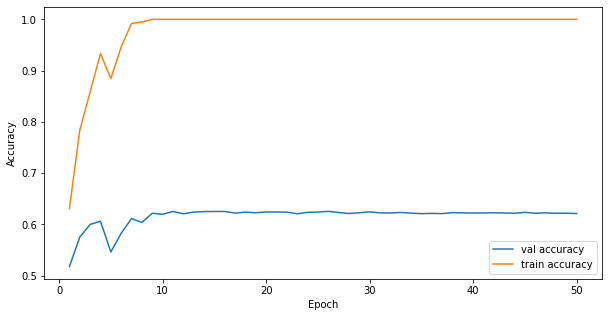

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(loss_history)) + 1, val_acc_history, label="val accuracy")
plt.plot(np.arange(len(loss_history)) + 1, train_acc_history, label="train accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [50]:
# compute accuracy on test data
valid(best_stl10_net, testloader)
valid_class(best_stl10_net, testloader, classes)

Accuracy of the network on the 10000 test images: 62 %
Accuracy of airplanes : 74 %
Accuracy of birds : 47 %
Accuracy of ships : 77 %
Accuracy of  cats : 48 %
Accuracy of  dogs : 60 %


#### *`Q3.3  Feature Space Visualization`*

In [76]:
################################
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

stl10_testset = STL10_Dataset(root='./data', train=False, transform=transform)
stl10_testloader = torch.utils.data.DataLoader(stl10_testset, batch_size=batch_size, shuffle=False, num_workers=4)
stl10_classes = ("airplanes", "birds", "ships", "cats", "dogs")

cifar10_testset = CIFAR10_loader(root="./data", train=False, transform=transform)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=False, num_workers=4)
cifar10_classes  = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cifar10_features = []
cifar10_labels = []
for i in range(500):
    image, label = cifar10_testset[i]
    features = best_net.extract_features(image.unsqueeze(0))
    features = features.view(1, -1)
    cifar10_features.append(features)
    cifar10_labels.append(label)
    
cifar10_features = torch.cat(cifar10_features, dim=0).numpy()
cifar10_labels = np.array(cifar10_labels)
    
stl10_features = []
stl10_labels = []
for i in range(500):
    image, label = stl10_testset[i]
    features = stl10_net.extract_features(image.unsqueeze(0))
    features = features.view(1, -1)
    stl10_features.append(features)
    stl10_labels.append(label)
    
stl10_features = torch.cat(stl10_features, dim=0).numpy()
stl10_labels = np.array(stl10_labels)

cifar10_tsne = TSNE(n_components=2).fit_transform(cifar10_features)
stl10_tsne = TSNE(n_components=2).fit_transform(stl10_features)
################################

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

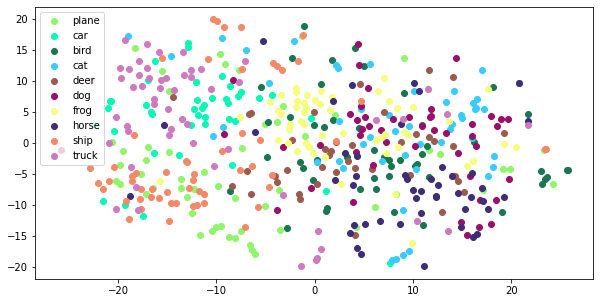

In [83]:
plt.figure(figsize=(10, 5))
for idx, class_ in enumerate(cifar10_classes):
    indices = np.argwhere(cifar10_labels == idx)
    plt.scatter(cifar10_tsne[indices, 0], cifar10_tsne[indices, 1], c=np.random.rand(3,), label=class_)
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

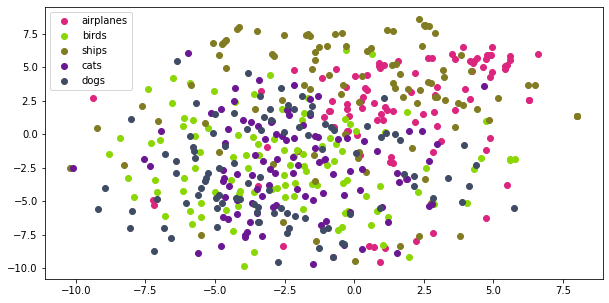

In [84]:
plt.figure(figsize=(10, 5))
for idx, class_ in enumerate(stl10_classes):
    indices = np.argwhere(stl10_labels == idx)
    plt.scatter(stl10_tsne[indices, 0], stl10_tsne[indices, 1], c=np.random.rand(3,), label=class_)
plt.legend()
plt.show()

###  `Bonus`

In [52]:
pass